In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

In [72]:
# Modern violet gradient color palette
COLORS = {
    'primary': '#667eea',
    'secondary': '#764ba2',
    'accent': '#f093fb',
    'highlight': '#4facfe',
    'dark': '#2d3561',
    'light': '#e0c3fc'
}

GRADIENT = ['#667eea', '#764ba2', '#a855f7', '#f093fb', '#fbc2eb']

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(GRADIENT)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


In [73]:
train = pd.read_csv('./data/playground-series-s6e2/train.csv')
test = pd.read_csv('./data/playground-series-s6e2/test.csv')

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (630000, 15)
Test Shape: (270000, 14)


In [74]:
print("=" * 80)
print("TRAIN DATA - FIRST 5 ROWS")
print("=" * 80)
display(train.head())

print("\n", "=" * 80)
print("TEST DATA - FIRST 5 ROWS")
print("=" * 80)
display(test.head())

TRAIN DATA - FIRST 5 ROWS


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence



TEST DATA - FIRST 5 ROWS


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


In [75]:
print("=" * 80)
print("TRAIN DATA - INFO")
print("=" * 80)
train.info()

TRAIN DATA - INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null 

In [76]:
TARGET = "Heart Disease"
ID_COL = "id"

train_cols = [col for col in train.columns if col not in [ID_COL, TARGET]]
test_cols = [col for col in test.columns if col not in [ID_COL]]

print(f"Target Variable: {TARGET}")
print(f"Number of Features: {len(train_cols)}")
print("\nFeature List: ")
for i, col in enumerate(train_cols, 1):
    print(f"   {i:2d}. {col}")

CATS = train[train_cols].select_dtypes(include=["object"]).columns.tolist()
NUMS = train[train_cols].select_dtypes(exclude=["object"]).columns.tolist()

print("\n", "="*80)
print(f"Categorical Features ({len(CATS)}): {CATS}")
print(f"Numerical Features ({len(NUMS)}): {NUMS}")

Target Variable: Heart Disease
Number of Features: 13

Feature List: 
    1. Age
    2. Sex
    3. Chest pain type
    4. BP
    5. Cholesterol
    6. FBS over 120
    7. EKG results
    8. Max HR
    9. Exercise angina
   10. ST depression
   11. Slope of ST
   12. Number of vessels fluro
   13. Thallium

Categorical Features (0): []
Numerical Features (13): ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


### 1. Basic Data Quality Checks

In [77]:
def check_missing_values(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing Count': missing.values,
        'Missing Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

    print(f'\n{"="*80}')
    print(f"{name} - MISSING VALUES ANALYSIS")
    print(f"{'='*80}")

    if len(missing_df) == 0:
        print("✓ No missing values found in the dataset.")
    else:
        display(missing_df)

    return missing_df

In [78]:
train_missing = check_missing_values(train, "TRAIN")
test_missing = check_missing_values(test, "TEST")


TRAIN - MISSING VALUES ANALYSIS
✓ No missing values found in the dataset.

TEST - MISSING VALUES ANALYSIS
✓ No missing values found in the dataset.


Duplicate Rows Check

In [79]:
print("="*80)
print("DUPLICATE ROWS CHECK")
print("="*80)

train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"Train Duplicates: {train_duplicates: ,} ({train_duplicates / len(train) * 100:.2f}%)")
print(f"Test Duplicates: {test_duplicates: ,} ({test_duplicates / len(test) * 100:.2f}%)")

DUPLICATE ROWS CHECK
Train Duplicates:  0 (0.00%)
Test Duplicates:  0 (0.00%)


Unique Values Count

In [80]:
print("="*80)
print("UNIQUE VALUES COUNT - ALL FEATURES")
print("="*80)

unique_counts = pd.DataFrame({
    'Feature': train_cols,
    'Train Unique': [train[col].nunique() for col in train_cols],
    'Test Unique': [test[col].nunique() for col in train_cols],
    'Train Sample Size': len(train),
    'Cardinality Ratio': [train[col].nunique() / len(train) * 100 for col in train_cols]
})

unique_counts = unique_counts.sort_values('Train Unique', ascending=False)
display(unique_counts)

UNIQUE VALUES COUNT - ALL FEATURES


,Feature,Train Unique,Test Unique,Train Sample Size,Cardinality Ratio
4,Cholesterol,150,145,630000,0.023810
7,Max HR,93,92,630000,0.014762
3,BP,66,64,630000,0.010476
9,ST depression,66,64,630000,0.010476
0,Age,42,43,630000,0.006667
2,Chest pain type,4,4,630000,0.000635
11,Number of vessels fluro,4,4,630000,0.000635
6,EKG results,3,3,630000,0.000476
10,Slope of ST,3,3,630000,0.000476
12,Thallium,3,3,630000,0.000476


Statistical Summary - Numerical Features

In [81]:
print("="*80)
print("STATISTICAL SUMMARY - NUMERICAL FEATURES (TRAIN)")
print("="*80)

display(train[NUMS].describe().T.style.background_gradient(cmap='viridis'))


STATISTICAL SUMMARY - NUMERICAL FEATURES (TRAIN)


,count,mean,std,min,25%,50%,75%,max
Age,630000.000000,54.136706,8.256301,29.000000,48.000000,54.000000,60.000000,77.000000
Sex,630000.000000,0.714735,0.451541,0.000000,0.000000,1.000000,1.000000,1.000000
Chest pain type,630000.000000,3.312752,0.851615,1.000000,3.000000,4.000000,4.000000,4.000000
BP,630000.000000,130.497433,14.975802,94.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,630000.000000,245.011814,33.681581,126.000000,223.000000,243.000000,269.000000,564.000000
FBS over 120,630000.000000,0.079987,0.271274,0.000000,0.000000,0.000000,0.000000,1.000000
EKG results,630000.000000,0.981660,0.998783,0.000000,0.000000,0.000000,2.000000,2.000000
Max HR,630000.000000,152.816763,19.112927,71.000000,142.000000,157.000000,166.000000,202.000000
Exercise angina,630000.000000,0.273725,0.445870,0.000000,0.000000,0.000000,1.000000,1.000000
ST depression,630000.000000,0.716028,0.948472,0.000000,0.000000,0.100000,1.400000,6.200000


### 2. Target Variable Analysis
Target Distribution

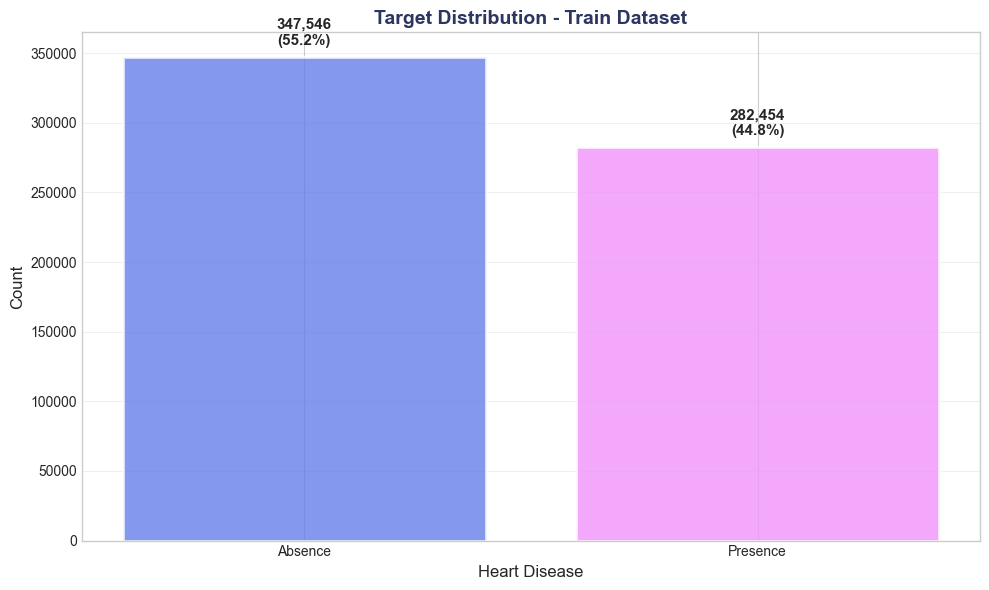

CLASS BALANCE ANALYSIS

Train Dataset: 
   Absence: 347,546 (55.17%)
   Presence: 282,454 (44.83%)

Imbalance Ratio: 1.23:1
✓ Classes are relatively balanced.


In [82]:
plt.figure(figsize=(10, 6))

target_counts_train = train[TARGET].value_counts().sort_index()
colors_train = [COLORS['primary'], COLORS["accent"]]
plt.bar(target_counts_train.index, target_counts_train.values, color=colors_train, alpha=0.8, edgecolor='white', linewidth=2)
plt.title("Target Distribution - Train Dataset", fontsize=14, fontweight='bold', color=COLORS['dark'])
plt.xlabel(TARGET, fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, (value, count) in enumerate(target_counts_train.items()):
    pct = count / len(train) * 100
    plt.text(i, count + len(train)*0.01, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*80)
print("CLASS BALANCE ANALYSIS")
print("="*80)
print(f"\nTrain Dataset: ")
for label, count in target_counts_train.items():
    print(f"   {label}: {count:,} ({count / len(train) * 100:.2f}%)")

imbalance_ratio = target_counts_train.max() / target_counts_train.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print("⚠ Moderate class imbalance detected. Consider stratified CV and balanced metrics.")
elif imbalance_ratio > 2.0:
    print("⚠⚠ Significant class imbalance detected. Consider SMOTE or class weights.")
else:
    print("✓ Classes are relatively balanced.")


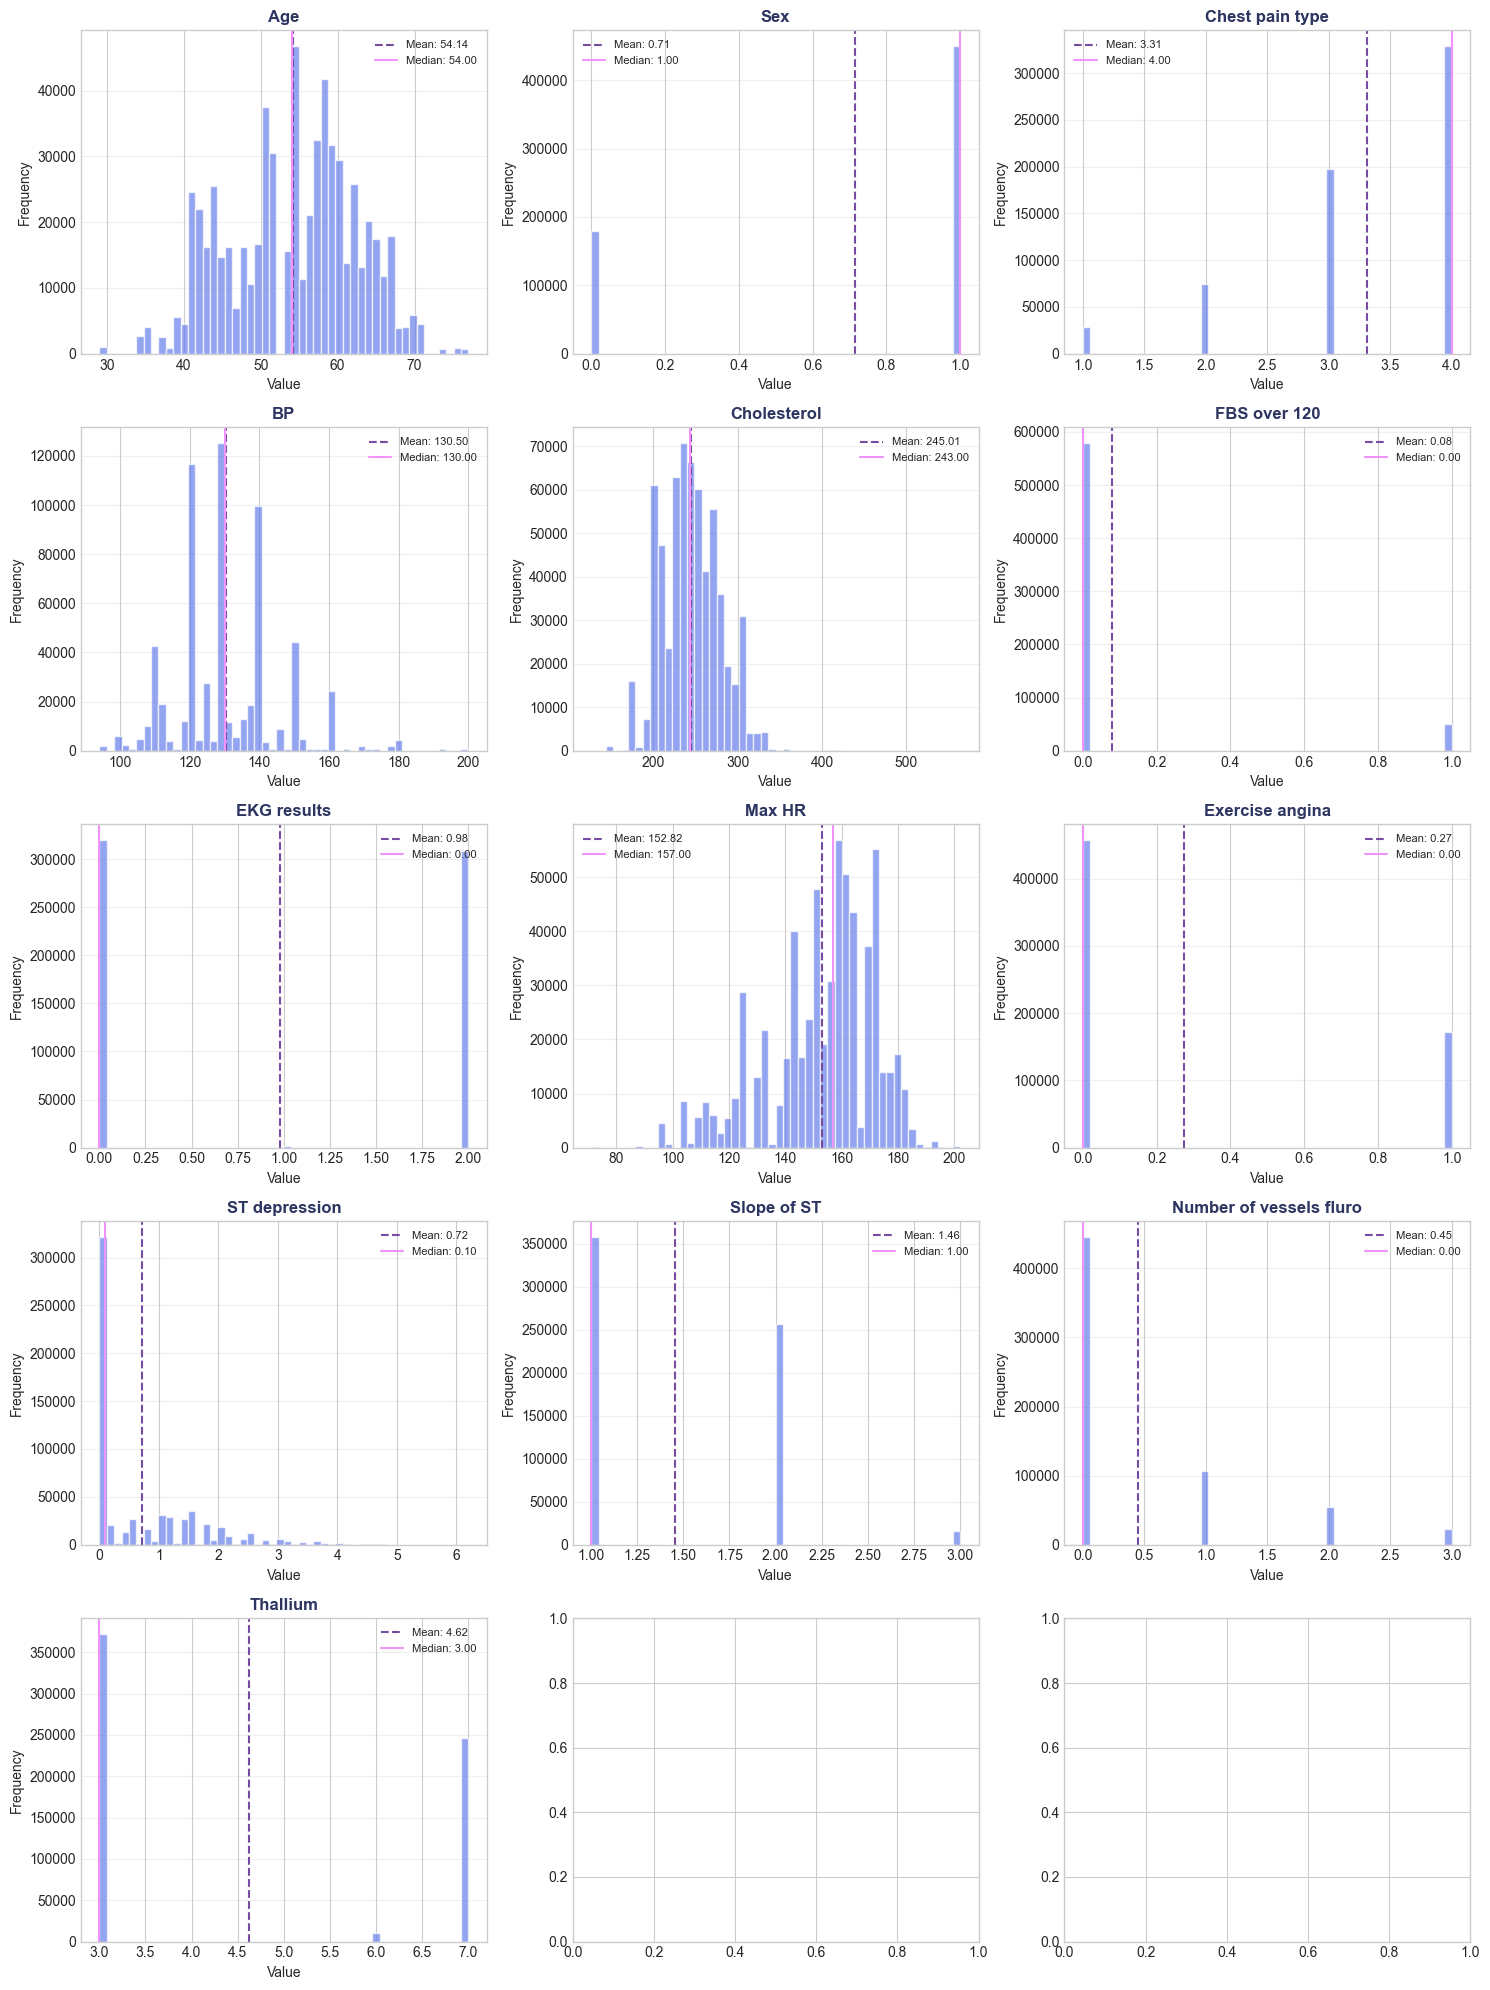

In [83]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    axes[i].hist(train[col], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
    axes[i].set_title(f"{col}", fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

    mean_val = train[col].mean()
    median_val = train[col].median()
    axes[i].axvline(mean_val, color=COLORS['secondary'], linestyle='--', label=f"Mean: {mean_val:.2f}")
    axes[i].axvline(median_val, color=COLORS['accent'], linestyle='-', label=f"Median: {median_val:.2f}")
    axes[i].legend(fontsize=8)
plt.tight_layout()

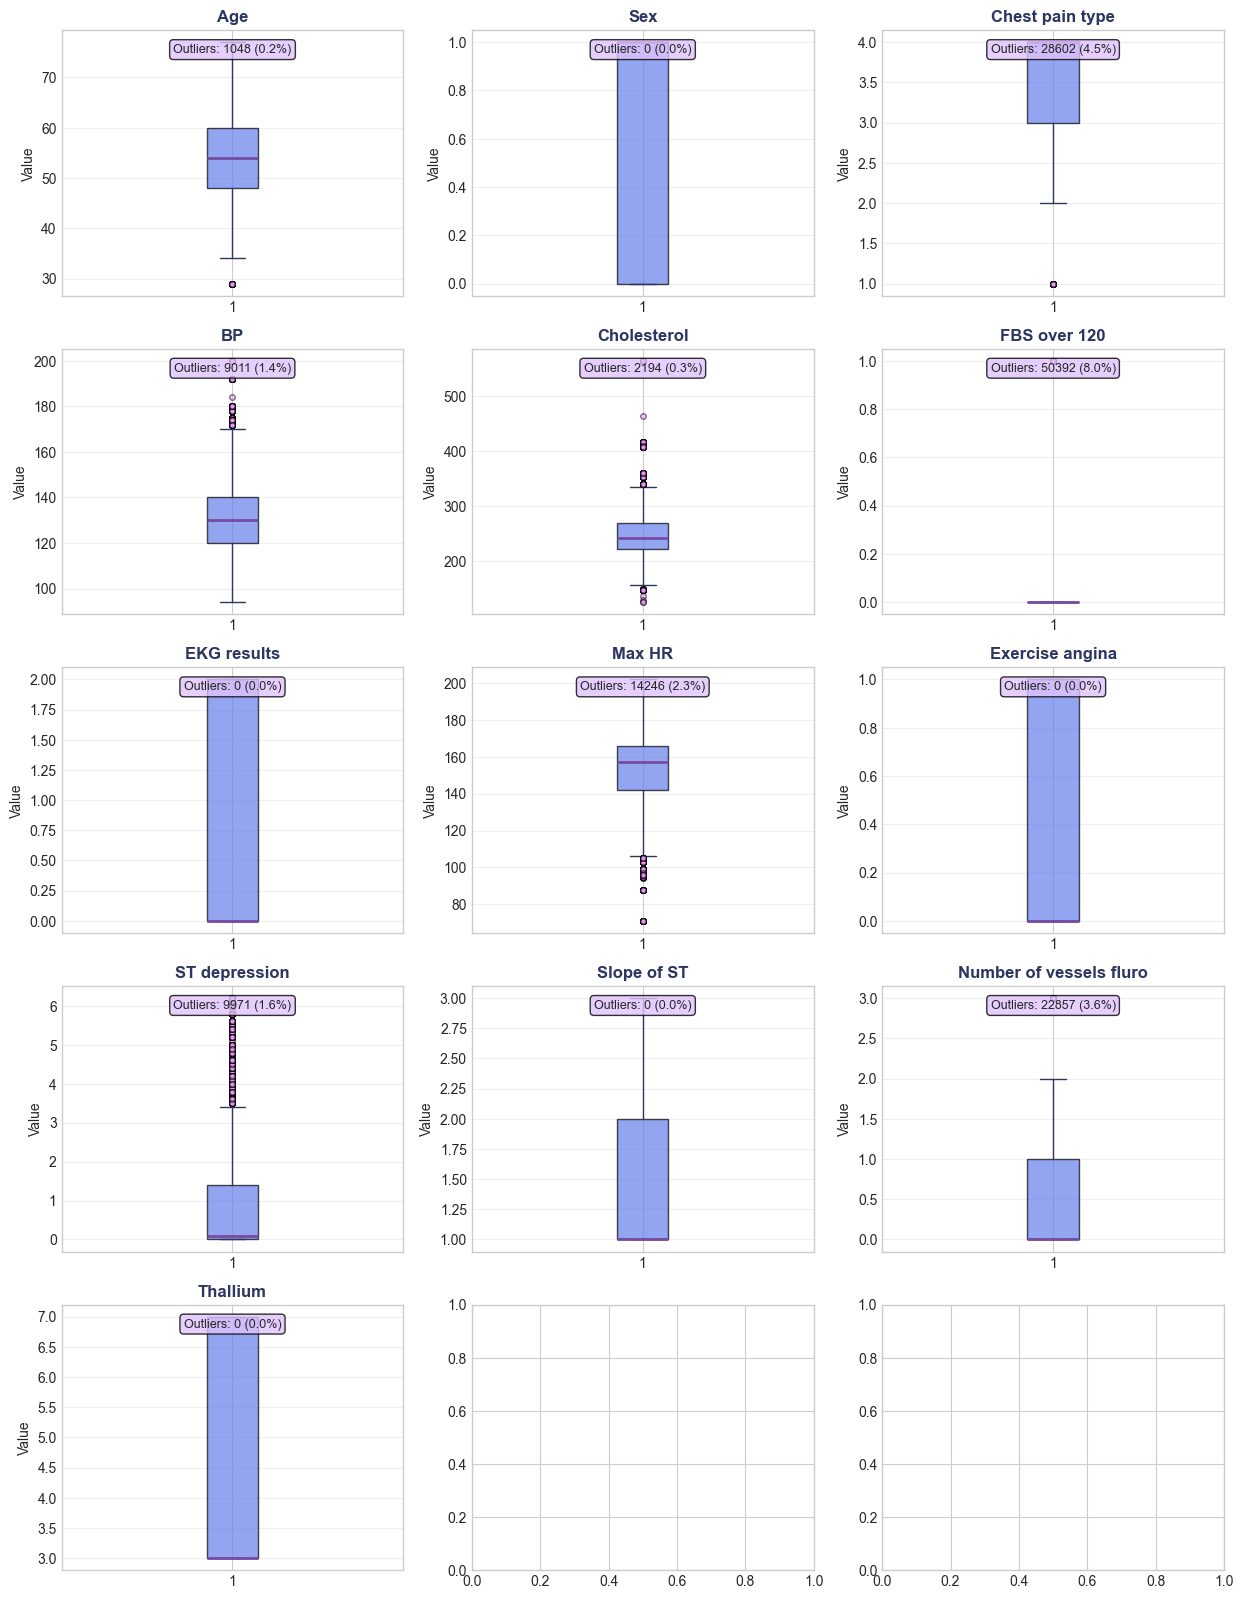

In [84]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    bp = axes[i].boxplot(train[col], vert=True, patch_artist=True, boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                        medianprops=dict(color=COLORS['secondary'], linewidth=2),
                        whiskerprops=dict(color=COLORS['dark']),
                        capprops=dict(color=COLORS['dark']),
                        flierprops=dict(marker='o', markerfacecolor=COLORS['accent'], markersize=4, alpha=0.5))
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_ylabel("Value", fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    outliers = ((train[col] < (q1 - 1.5 * iqr)) | (train[col] > (q3 + 1.5 * iqr))).sum()
    outlier_pct = outliers / len(train) * 100

    axes[i].text(0.5, 0.95, f'Outliers: {outliers} ({outlier_pct:.1f}%)', transform=axes[i].transAxes, ha='center', va='top', bbox=dict(boxstyle='round', facecolor=COLORS['light'], alpha=0.8), fontsize=9)

In [85]:
skew_kurt_df = pd.DataFrame({
    'Feature': NUMS,
    'Skewness': [train[col].skew() for col in NUMS],
    'Kurtosis': [train[col].kurtosis() for col in NUMS],
    'Mean': [train[col].mean() for col in NUMS],
    'Std': [train[col].std() for col in NUMS]
})

skew_kurt_df['Skew_Type'] = skew_kurt_df['Skewness'].apply(lambda x: 'Highly Right' if x > 1 else ('Right' if x > 0.5 else ('Symmetric' if abs(x) <= 0.5 else ('Left' if x < -0.5 else 'Highly Left'))))

skew_kurt_df = skew_kurt_df.sort_values('Skewness', key=abs, ascending=False)

print('='*80)
print('SKEWNESS AND KURTOSIS ANALYSIS')
print('='*80)
display(skew_kurt_df.style.background_gradient(cmap='coolwarm'))

print("\nInterpretation:")
print("  • Skewness > 1 or < -1: Highly skewed (consider log transform)")
print("  • Skewness between -0.5 and 0.5: Approximately symmetric")
print("  • Kurtosis > 3: Heavy tails (more outliers)")
print("  • Kurtosis < 3: Light tails (fewer outliers)")

SKEWNESS AND KURTOSIS ANALYSIS


,Feature,Skewness,Kurtosis,Mean,Std,Skew_Type
5,FBS over 120,3.096606,7.588996,0.079987,0.271274,Highly Right
11,Number of vessels fluro,1.736669,2.096608,0.451040,0.798549,Highly Right
9,ST depression,1.328429,1.374855,0.716028,0.948472,Highly Right
2,Chest pain type,-1.085939,0.368411,3.312752,0.851615,Left
8,Exercise angina,1.014983,-0.969812,0.273725,0.445870,Highly Right
1,Sex,-0.951123,-1.095368,0.714735,0.451541,Left
7,Max HR,-0.754556,0.203852,152.816763,19.112927,Left
10,Slope of ST,0.630518,-0.736092,1.455871,0.545192,Right
3,BP,0.629283,0.933183,130.497433,14.975802,Right
12,Thallium,0.381173,-1.844162,4.618873,1.950007,Symmetric



Interpretation:
  • Skewness > 1 or < -1: Highly skewed (consider log transform)
  • Skewness between -0.5 and 0.5: Approximately symmetric
  • Kurtosis > 3: Heavy tails (more outliers)
  • Kurtosis < 3: Light tails (fewer outliers)


In [86]:
if len(CATS) > 0:
    n_cols = 2
    n_rows = (len(CATS) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, col in enumerate(CATS):
        cat_counts = train[col].value_counts().sort_index()
        
        axes[i].bar(range(len(cat_counts)), cat_counts.values, color=GRADIENT[:len(cat_counts)], 
                   alpha=0.8, edgecolor='white', linewidth=2)
        axes[i].set_xticks(range(len(cat_counts)))
        axes[i].set_xticklabels(cat_counts.index, rotation=45, ha='right')
        axes[i].set_title(f'{col}', fontsize=12, fontweight='bold', color=COLORS['dark'])
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].grid(axis='y', alpha=0.3)
        
        for j, (label, count) in enumerate(cat_counts.items()):
            pct = count / len(train) * 100
            axes[i].text(j, count + len(train)*0.01, f'{count:,}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontsize=9)
    
    for i in range(len(CATS), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Distribution of Categorical Features - Train Dataset', fontsize=16, fontweight='bold', color=COLORS['dark'], y=1.002)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features found.")


No categorical features found.


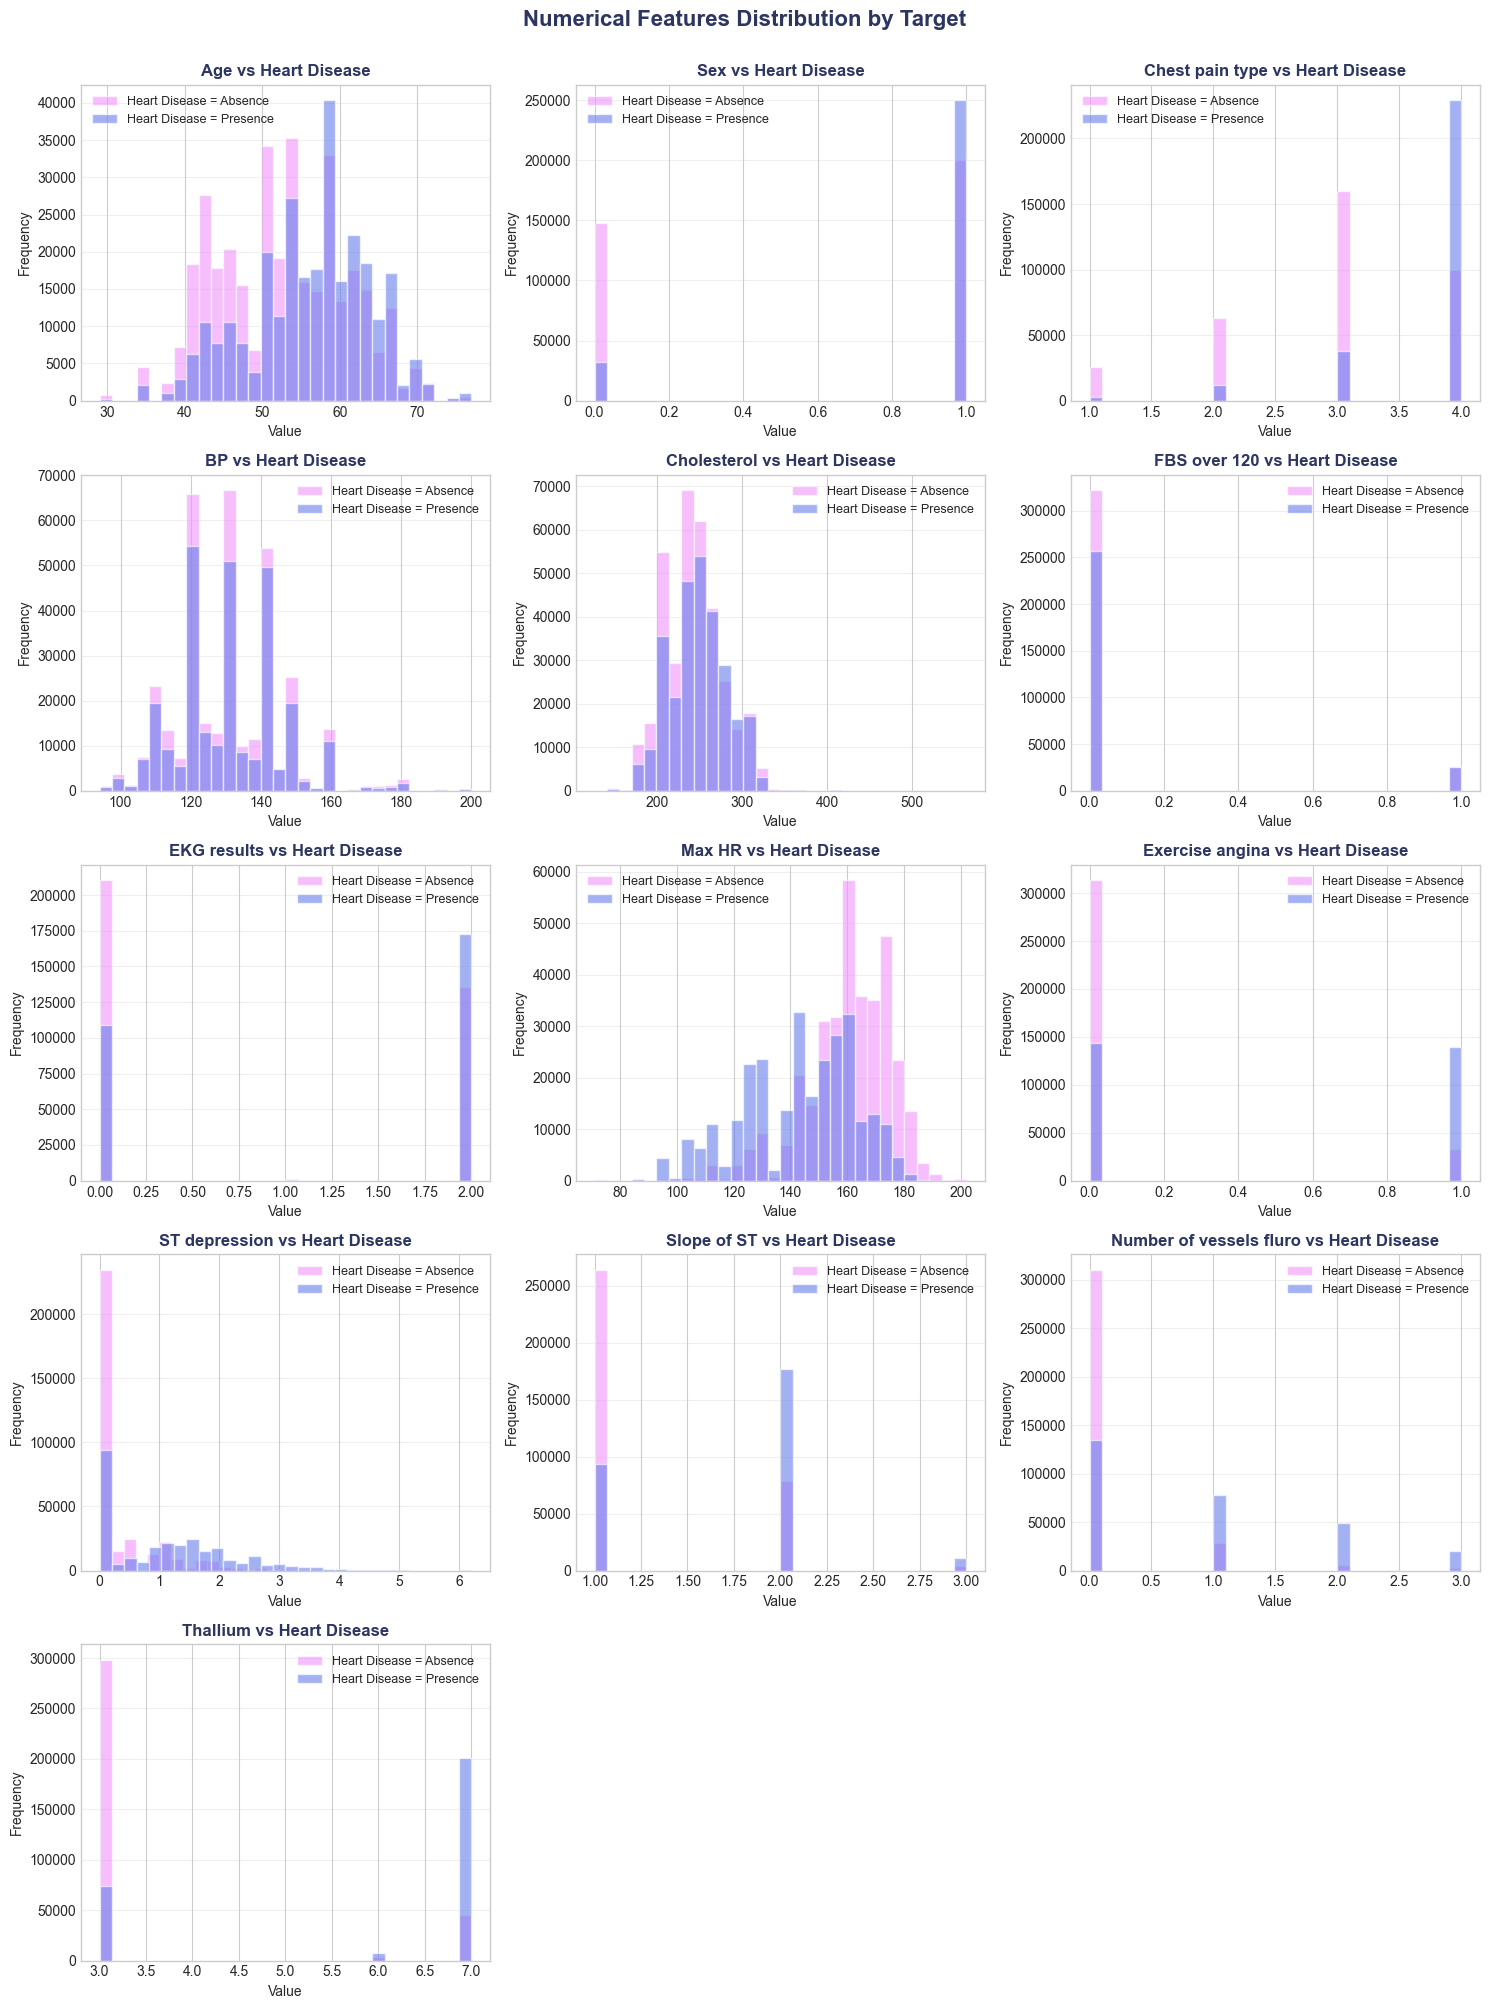

In [87]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    for target_val in sorted(train[TARGET].unique()):
        data = train[train[TARGET] == target_val][col]
        axes[i].hist(data, bins=30, alpha=0.6, label=f'{TARGET} = {target_val}', color=COLORS['primary'] if target_val == train[TARGET].unique()[0] else COLORS['accent'], edgecolor='white')

    axes[i].set_title(f'{col} vs {TARGET}', fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(axis='y', alpha=0.3)

for i in range(len(NUMS), len(axes)):
    axes[i].axis('off')

plt.suptitle("Numerical Features Distribution by Target", fontsize=16, fontweight='bold', color=COLORS['dark'], y=1.002)
plt.tight_layout()
plt.show() 

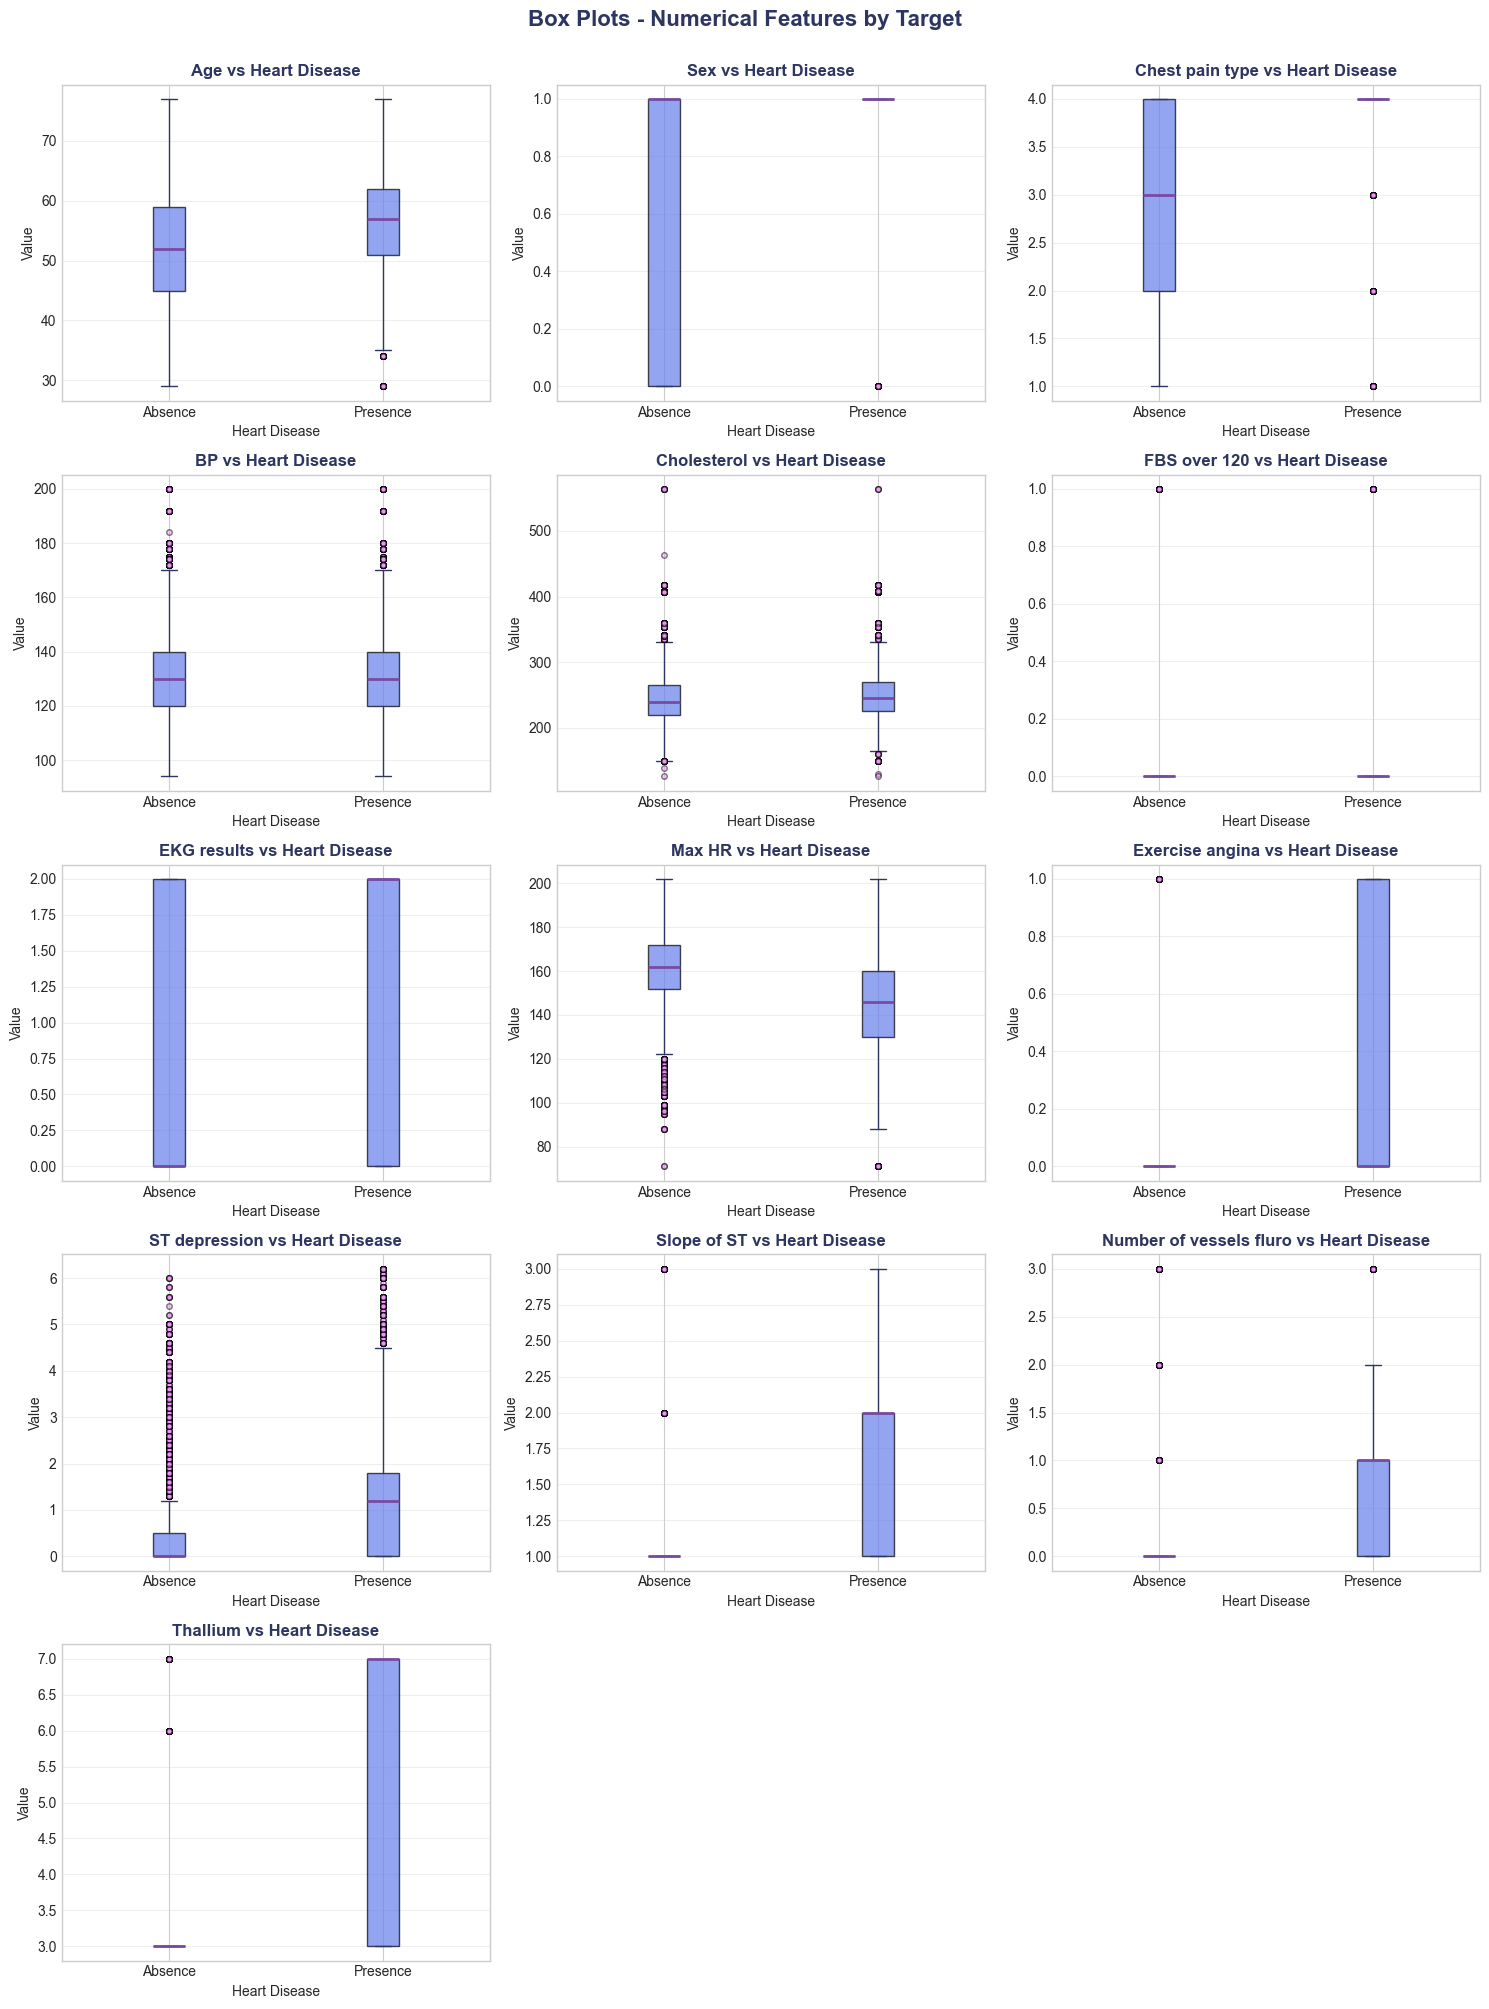

In [88]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    train_boxplot = train[[col, TARGET]].copy()
    train_boxplot[TARGET] = train_boxplot[TARGET].astype(str)
    
    bp = axes[i].boxplot([train[train[TARGET] == val][col].values for val in sorted(train[TARGET].unique())],
                         tick_labels=sorted(train[TARGET].unique()),
                         patch_artist=True,
                         boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                         medianprops=dict(color=COLORS['secondary'], linewidth=2),
                         whiskerprops=dict(color=COLORS['dark']),
                         capprops=dict(color=COLORS['dark']),
                         flierprops=dict(marker='o', markerfacecolor=COLORS['accent'], markersize=4, alpha=0.5))
    
    axes[i].set_title(f'{col} vs {TARGET}', fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_xlabel(TARGET, fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

for i in range(len(NUMS), len(axes)):
    axes[i].axis('off')

plt.suptitle('Box Plots - Numerical Features by Target', fontsize=16, fontweight='bold', color=COLORS['dark'], y=1.002)
plt.tight_layout()
plt.show()

In [89]:
print('='*80)
print('STATISTICAL SIGNIFICANCE TEST (Numerical Features vs Target)')
print('='*80)
print("\nUsing Mann-Whitney U Test (non-parametric)")
print("H0: The distribution are the same")
print("H1: The distributions are different")
print(f"Significance Level: ⍺ = 0.05\n")

significance_results = []

for col in NUMS:
    groups = [train[train[TARGET] == val][col].values for val in sorted(train[TARGET].unique())]

    if len(groups) == 2:
        stat, p_value = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')

        significance_results.append({
            'Feature': col,
            'Test_Statistic': stat,
            'P_Value': p_value,
            'Significant': "Yes" if p_value < 0.05 else "No",
            "Effect": "Strong" if p_value < 0.01 else ("Moderate" if p_value < 0.05 else "Weak")
        })

sig_df = pd.DataFrame(significance_results).sort_values('P_Value')
display(sig_df.style.background_gradient(cmap='RdYlGn_r'))

print(f"\nSignificant Features (p < 0.05): {sig_df[sig_df['Significant'] == 'Yes'].shape[0]}/{len(NUMS)}")


STATISTICAL SIGNIFICANCE TEST (Numerical Features vs Target)

Using Mann-Whitney U Test (non-parametric)
H0: The distribution are the same
H1: The distributions are different
Significance Level: ⍺ = 0.05



,Feature,Test_Statistic,P_Value,Significant,Effect
0,Age,36747944418.500000,0.000000,Yes,Strong
1,Sex,33821991183.000000,0.000000,Yes,Strong
2,Chest pain type,22747841890.500000,0.000000,Yes,Strong
4,Cholesterol,43889513411.000000,0.000000,Yes,Strong
6,EKG results,38268651767.000000,0.000000,Yes,Strong
7,Max HR,74204284951.500000,0.000000,Yes,Strong
8,Exercise angina,29638821411.000000,0.000000,Yes,Strong
9,ST depression,26143741179.500000,0.000000,Yes,Strong
10,Slope of ST,28023624776.500000,0.000000,Yes,Strong
11,Number of vessels fluro,27992132670.500000,0.000000,Yes,Strong



Significant Features (p < 0.05): 12/13


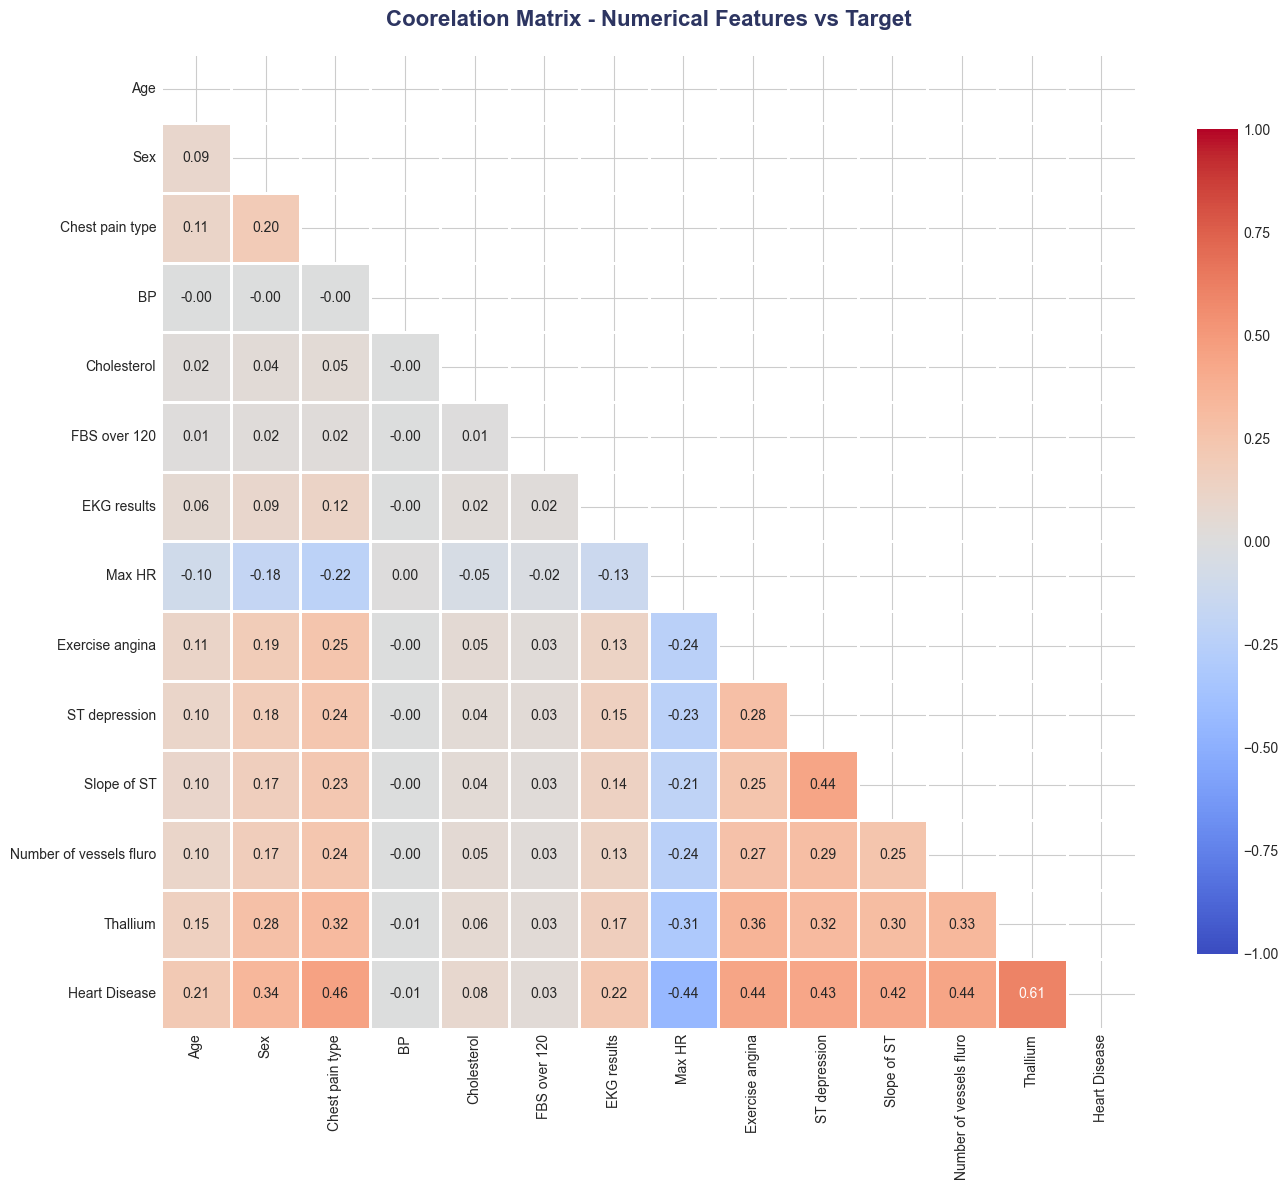

HIGH CORRELATIONS (|r| > 0.7)
✓ No high correlations found (|r| > 0.7)


In [90]:
corr_data = train[NUMS + [TARGET]].copy()

if corr_data[TARGET].dtype == 'object':
    target_mapping = {val: idx for idx, val in enumerate(sorted(corr_data[TARGET].unique()))}
    corr_data[TARGET] = corr_data[TARGET].map(target_mapping)

corr_matrix = corr_data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidth=1, cbar_kws={'shrink': 0.8}, ax=ax)

ax.set_title('Coorelation Matrix - Numerical Features vs Target', fontsize=16, fontweight='bold', color=COLORS['dark'], pad=20)

plt.tight_layout()
plt.show()

print("="*80)
print("HIGH CORRELATIONS (|r| > 0.7)")
print("="*80)

high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    display(high_corr_df)
    print("\n⚠ High multicollinearity detected. Consider feature selection or regularization.")
else:
    print("✓ No high correlations found (|r| > 0.7)")

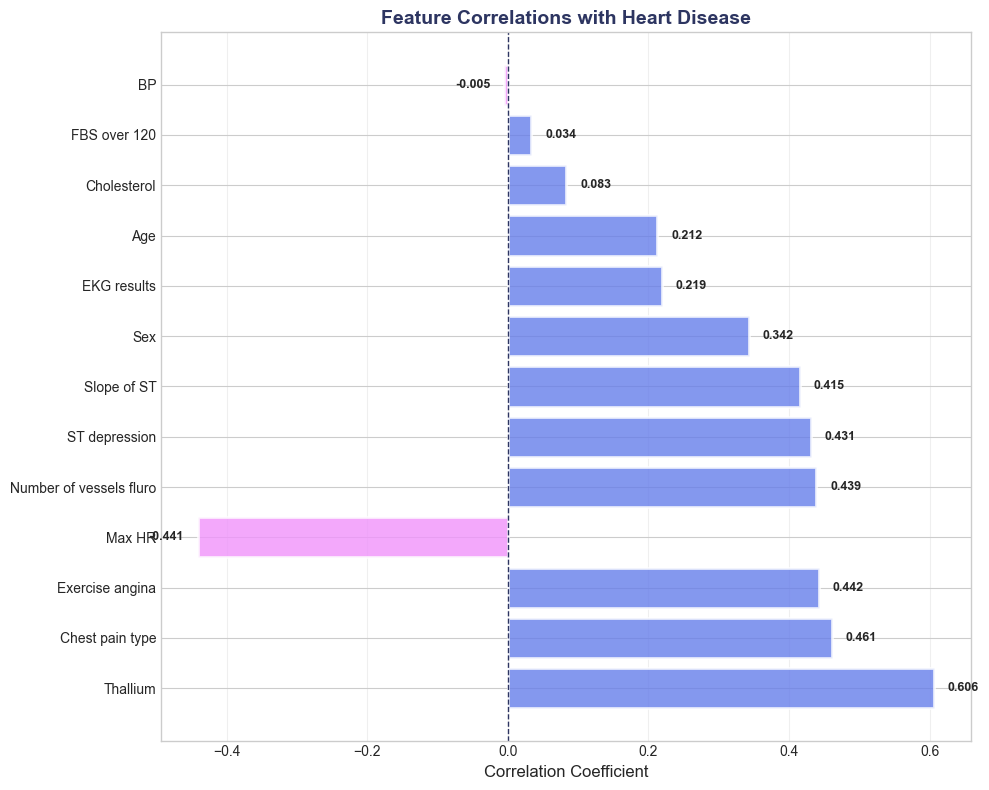

TOP 5 POSITIVELY CORRELATED FEATURES WITH Heart Disease
Thallium                   0.605776
Chest pain type            0.460684
Exercise angina            0.441864
Max HR                    -0.440985
Number of vessels fluro    0.438604
Name: Heart Disease, dtype: float64

TOP 5 NEGATIVELY CORRELATED FEATURES WITH Heart Disease
EKG results     0.218961
Age             0.212091
Cholesterol     0.082753
FBS over 120    0.033570
BP             -0.005181
Name: Heart Disease, dtype: float64


In [91]:
target_corr = corr_matrix[TARGET].drop(TARGET).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

colors = [COLORS['primary'] if x > 0 else COLORS['accent'] for x in target_corr.values]
bars = ax.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.8, edgecolor='white', linewidth=2)

ax.set_yticks(range(len(target_corr)))
ax.set_yticklabels(target_corr.index, fontsize=10)
ax.set_xlabel("Correlation Coefficient", fontsize=12)
ax.set_title(f"Feature Correlations with {TARGET}", fontsize=14, fontweight='bold', color=COLORS['dark'])
ax.axvline(0, color=COLORS['dark'], linewidth=1, linestyle='--')
ax.grid(axis='x', alpha=0.3)

for i, (feat, val) in enumerate(target_corr.items()):
    ax.text(val + (0.02 if val > 0 else -0.02), i, f'{val:.3f}', va='center', ha='left' if val > 0 else 'right', fontsize=9, fontweight='bold')
    
plt.tight_layout()
plt.show()

print("="*80)
print(f"TOP 5 POSITIVELY CORRELATED FEATURES WITH {TARGET}")
print("="*80)
print(target_corr.head())

print("\n" + "="*80)
print(f"TOP 5 NEGATIVELY CORRELATED FEATURES WITH {TARGET}")
print("="*80)
print(target_corr.tail())

KeyError: 'feature'

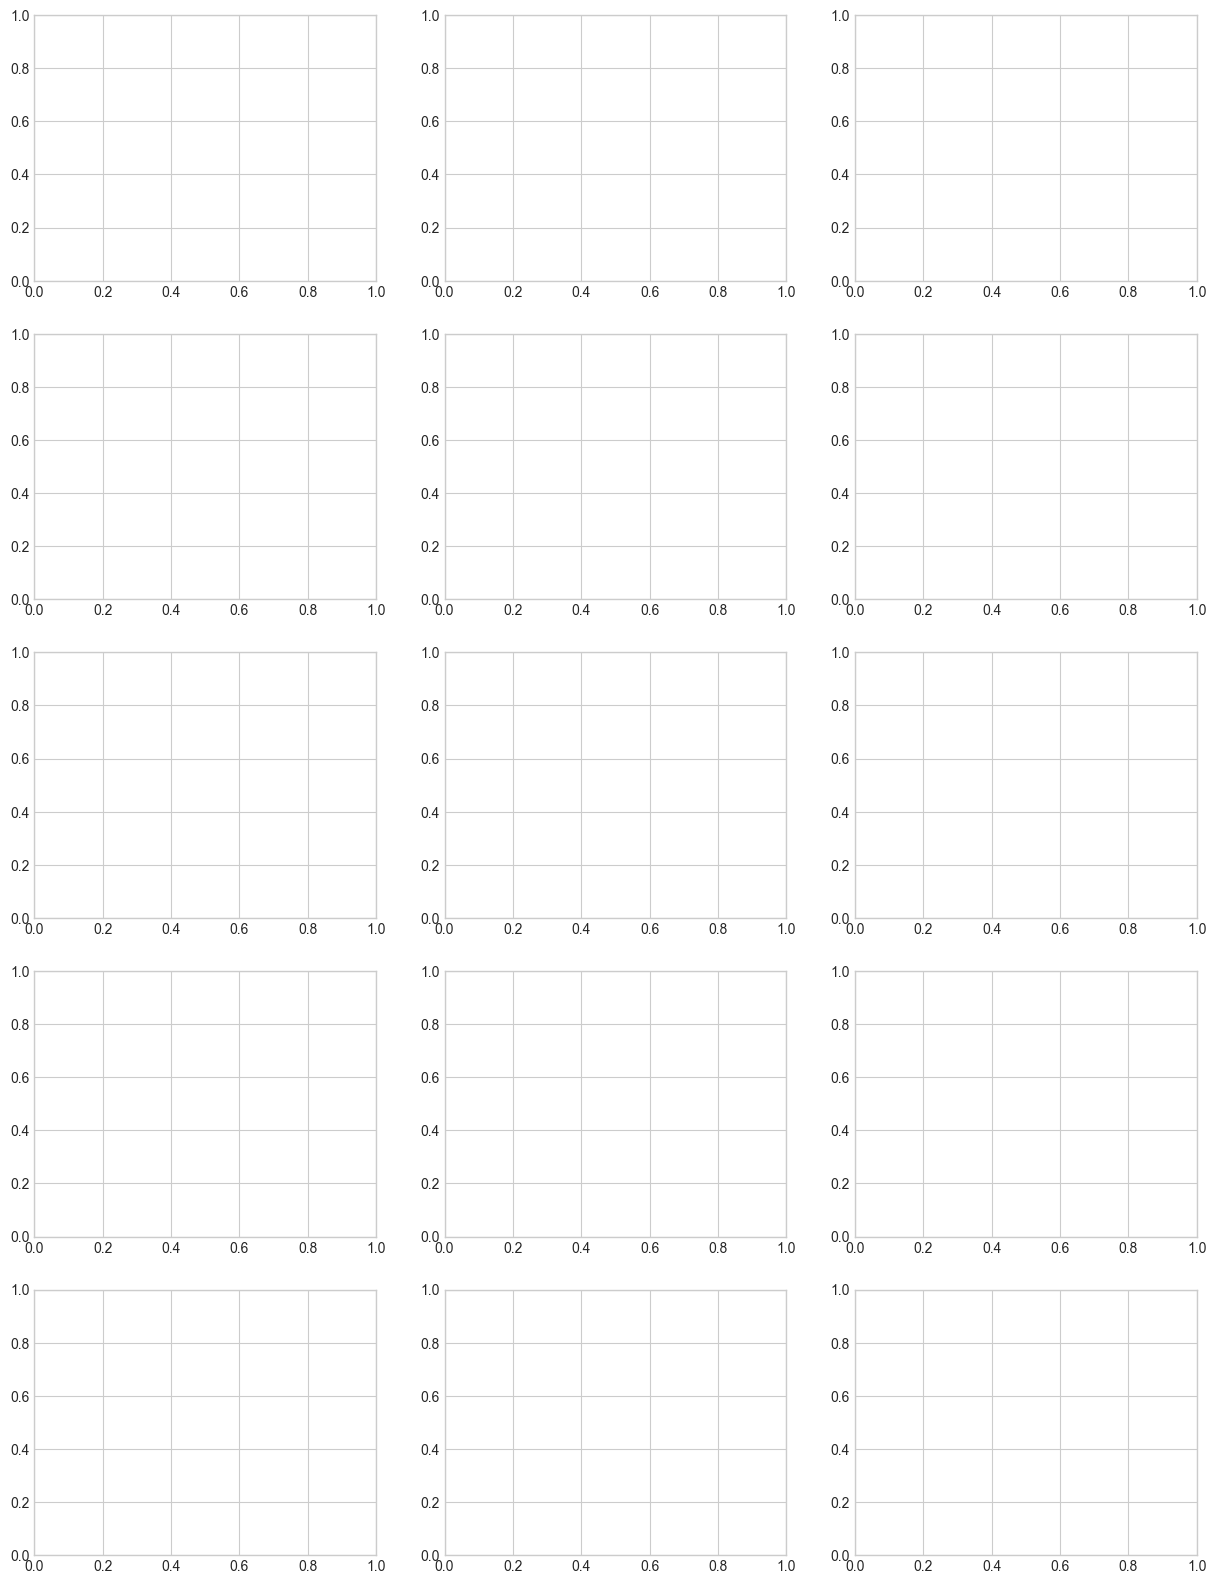

In [92]:
df_combined = pd.DataFrame()

for col in NUMS:
    temp_train = train[col].copy()
    temp_train.name = 'value'
    temp_train_df = temp_train.to_frame()
    temp_train_df['source'] = 'Train'
    temp_train_df['feature'] = col
    
    temp_test = test[col].copy()
    temp_test.name = 'value'
    temp_test_df = temp_test.to_frame()
    temp_test_df['source'] = 'Test'
    temp_test_df['feature'] = col

n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    data_subset = df_combined[df_combined['feature'] == col]
    
    for source in ['Train', 'Test', 'Original']:
        source_data = data_subset[data_subset['source'] == source]['value']
        if len(source_data) > 0:
            axes[i].hist(source_data, bins=30, alpha=0.5, label=source, density=True)
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(axis='y', alpha=0.3)

for i in range(len(NUMS), len(axes)):
    axes[i].axis('off')

plt.suptitle('Feature Distributions: Train vs Test vs Original', fontsize=16, fontweight='bold', color=COLORS['dark'], y=1.002)
plt.tight_layout()
plt.show()


In [ ]:
print("="*80)
print("KOLMOGOROV-SMIRNOV TEST (Train vs Test)")
print("="*80)
print("H0: Distributions are the same")
print("H1: Distributions are different")
print(f"Significance Level: α = 0.05\n")

ks_results = []

for col in NUMS:
    stat, p_value = stats.ks_2samp(train[col], test[col])
    
    ks_results.append({
        'Feature': col,
        'KS_Statistic': stat,
        'P_Value': p_value,
        'Same_Distribution': 'Yes' if p_value > 0.05 else 'No',
        'Interpretation': 'Aligned' if p_value > 0.05 else 'Different'
    })

ks_df = pd.DataFrame(ks_results).sort_values('P_Value', ascending=False)
display(ks_df.style.background_gradient(subset=['P_Value'], cmap='RdYlGn'))

aligned_count = ks_df[ks_df['Same_Distribution'] == 'Yes'].shape[0]
print(f"\n✓ Aligned Features (Train vs Test): {aligned_count}/{len(NUMS)}")

if aligned_count / len(NUMS) > 0.8:
    print("✓ Train and Test distributions are well-aligned. Local CV should be reliable.")
else:
    print("⚠ Significant distribution differences detected. Consider domain adaptation techniques.")


KOLMOGOROV-SMIRNOV TEST (Train vs Test)
H0: Distributions are the same
H1: Distributions are different
Significance Level: α = 0.05



,Feature,KS_Statistic,P_Value,Same_Distribution,Interpretation
5,FBS over 120,0.000065,1.000000,Yes,Aligned
12,Thallium,0.000311,1.000000,Yes,Aligned
8,Exercise angina,0.000930,0.996677,Yes,Aligned
4,Cholesterol,0.001396,0.854634,Yes,Aligned
1,Sex,0.001580,0.732378,Yes,Aligned
6,EKG results,0.001618,0.704917,Yes,Aligned
7,Max HR,0.001737,0.618227,Yes,Aligned
2,Chest pain type,0.002090,0.380466,Yes,Aligned
0,Age,0.002162,0.339312,Yes,Aligned
11,Number of vessels fluro,0.002210,0.313949,Yes,Aligned



✓ Aligned Features (Train vs Test): 13/13
✓ Train and Test distributions are well-aligned. Local CV should be reliable.


In [ ]:
summary_comparison = pd.DataFrame()

for col in NUMS:
    summary_comparison = pd.concat([summary_comparison, pd.DataFrame({
        'Feature': [col],
        'Train_Mean': [train[col].mean()],
        'Test_Mean': [test[col].mean()],
        'Train_Std': [train[col].std()],
        'Test_Std': [test[col].std()],
        'Train_Median': [train[col].median()],
        'Test_Median': [test[col].median()],
        'Mean_Diff_%': [abs(train[col].mean() - test[col].mean()) / train[col].mean() * 100]
    })], ignore_index=True)

summary_comparison = summary_comparison.sort_values('Mean_Diff_%', ascending=False)

print("="*80)
print("SUMMARY STATISTICS COMPARISON (Train vs Test)")
print("="*80)
display(summary_comparison.style.background_gradient(subset=['Mean_Diff_%'], cmap='YlOrRd'))

print("\n⚠ Features with >5% mean difference may indicate distribution shift.")


SUMMARY STATISTICS COMPARISON (Train vs Test)


,Feature,Train_Mean,Test_Mean,Train_Std,Test_Std,Train_Median,Test_Median,Mean_Diff_%
11,Number of vessels fluro,0.451040,0.454800,0.798549,0.801270,0.000000,0.000000,0.833700
8,Exercise angina,0.273725,0.274656,0.445870,0.446341,0.000000,0.000000,0.339815
6,EKG results,0.981660,0.978493,0.998783,0.998686,0.000000,0.000000,0.322691
9,ST depression,0.716028,0.718082,0.948472,0.947417,0.100000,0.100000,0.286923
10,Slope of ST,1.455871,1.459356,0.545192,0.546186,1.000000,1.000000,0.239316
1,Sex,0.714735,0.716315,0.451541,0.450787,1.000000,1.000000,0.221046
5,FBS over 120,0.079987,0.080052,0.271274,0.271374,0.000000,0.000000,0.080701
2,Chest pain type,3.312752,3.315107,0.851615,0.851762,4.000000,4.000000,0.071090
3,BP,130.497433,130.555089,14.975802,15.007908,130.000000,130.000000,0.044181
0,Age,54.136706,54.159870,8.256301,8.255471,54.000000,54.000000,0.042788



⚠ Features with >5% mean difference may indicate distribution shift.


In [93]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [94]:
N_SPLITS = 5
TARGET_COL = "Heart Disease"
ID_COL = 'id'

# 타깃 인코딩
# Absence/Presence -> 0/1
def encode_target(y: pd.Series) -> pd.Series:
    mapping = {'Absence': 0, 'Presence': 1}
    return y.map(mapping).astype(int)

In [95]:
# 원본 분리
X_train_raw = train.drop(columns=[TARGET_COL, ID_COL]).copy()
y_train = encode_target(train[TARGET_COL])
X_test_raw = test.drop(columns=[ID_COL]).copy()

In [96]:
# FE 함수

# EDA 근거: 저카디널리티 피쳐를 범주형으로 취급
LOW_CARD_CATS = [
    "Sex",
    "Chest pain type",
    "FBS over 120",
    "EKG results",
    "Exercise angina",
    "Slope of ST",
    "Number of vessels fluro",
    "Thallium"
]

CONT_COLS = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]

def apply_exp1_cast_categories(df: pd.DataFrame) -> pd.DataFrame:
    """Exp-1: 저카디널리티 변수 category 캐스팅"""
    out = df.copy()
    for col in LOW_CARD_CATS:
        if col in out.columns:
            out[col] = out[col].astype('category')
    return out


In [97]:
def apply_exp2_add_interactions(df: pd.DataFrame) -> pd.DataFrame:
    """Exp-2: Exp-1 + 상호작용 피처"""
    out = apply_exp1_cast_categories(df)

    # 상효작용 (EDA 기반 우선 후보)
    if {"ST depression", "Exercise angina"}.issubset(out.columns):
        out['stdep_x_exang'] = out['ST depression'].astype(float) * out["Exercise angina"].astype(float)
    
    if {"Chest pain type", "Max HR"}.issubset(out.columns):
        out['cp_x_maxhr'] = out['Chest pain type'].astype(float) * out['Max HR'].astype(float)

    if {"Number of vessels fluro", "Thallium"}.issubset(out.columns):
        out['vessels_x_thallium'] = out['Number of vessels fluro'].astype(float) * out['Thallium'].astype(float)

    if {"Sex", "Age"}.issubset(out.columns):
        out['sex_x_age'] = out['Sex'].astype(float) * out['Age'].astype(float)

    # BP는 단독 유의성 약했으므로 조합으로 보완
    if {"BP", "Age"}.issubset(out.columns):
        out['bp_x_age'] = out['BP'].astype(float) * out['Age'].astype(float)

    return out

In [98]:
def apply_exp3_add_bins_and_clips(df: pd.DataFrame) -> pd.DataFrame:
    """Exp-3: Exp-2 + 연속형 bin/clip"""
    out = apply_exp2_add_interactions(df)

    # 연속평 클리핑 (train quantile 기준 사용하는 것이 원칙)
    # 여기선 간단 버전: 개별 DF quantile 사용
    for col in ["ST depression", "Cholesterol", "Max HR"]:
        if col in out.columns:
            q01, q99 = out[col].quantile([0.01, 0.99])
            out[f"{col}_clip"] = out[col].clip(q01, q99)

    # 연속평 binning
    if 'Age' in out.columns:
        out['Age_bin'] = pd.qcut(out['Age'], q=5, duplicates='drop').astype('category')

    if 'ST depression' in out.columns:
        out['ST_depression_bin'] = pd.qcut(out["ST depression"], q=5, duplicates='drop').astype('category')

    # BP high flag
    if 'BP' in out.columns:
        threshold = out['BP'].quantile(0.9)
        out['bp_high_flag'] = (out['BP'] >= threshold).astyle(int)
    
    return out

In [99]:
# 2) 공통 전처리 + 모델 평가 유틸
def build_preprocessor(X: pd.DataFrame):
    cat_cols = X.select_dtypes(include=["category", "object"]).columns
    num_cols = [c for c in X.columns if c not in cat_cols]

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy='most_frequent')),
            ("ohe", OneHotEncoder(handle_unknown='ignore')),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
        ],
        remainder='drop',
    )
    return preprocessor

In [100]:
def evaluate_cv_auc(X: pd.DataFrame, y: pd.Series, model=None, n_splits: int = N_SPLITS):
    if model is None:
        model = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=2,
            n_jobs=-1,
        )

    preprocessor = build_preprocessor(X)
    clf = Pipeline(steps=[("prep", preprocessor), ("model", model)])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    auc_scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1,)
    return auc_scores

In [101]:
# 3) 실험 실행

experiments = {
    "Exp-1_cast_categories": apply_exp1_cast_categories,
    "Exp-2_add_interactions": apply_exp2_add_interactions,
    "Exp-3_add_bins_and_clips": apply_exp3_add_bins_and_clips,
}

results = []
for exp_name, fe_fn in experiments.items():
    X_fe = fe_fn(X_train_raw)
    scores = evaluate_cv_auc(X_fe, y_train)
    results.append(
        {
            "experiment": exp_name,
            "cv_auc_mean": scores.mean(),
            "cv_auc_std": scores.std(),
            "n_features_after_fe": X_fe.shape[1],
        }
    )

    print(f"{exp_name}: AUC={scores.mean():.6f} ± {scores.std():.6f}, features={X_fe.shape[1]}")

result_df = pd.DataFrame(results).sort_values('cv_auc_mean', ascending=False)
display(result_df)

/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@

Exp-1_cast_categories: AUC=nan ± nan, features=13


/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/junochoi/Documents/Study/Kaggle/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@

Exp-2_add_interactions: AUC=nan ± nan, features=18


AttributeError: 'Series' object has no attribute 'astyle'